In [1]:
import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


In [2]:
import torch
import numpy as np


exp_name = "CUDA-01-00"
pair_algo = "ternary-500"
reward_model_algo = "MR-linear"

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

TRAJECTORY_LENGTH = 25

In [3]:
from data_generation.data_research import predict_rewards
from data_loading.load_data import load_dataset


def predict_only_rewards(
    env_name,
    exp_name,
    pair_algo,
    reward_model_algo,
):
    result = predict_rewards(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_algo,
        reward_model_algo=reward_model_algo,
    )

    pred_reward_list = [r for (_, r, _, _) in result]
    pred_reward_list = np.array(pred_reward_list)

    return pred_reward_list



def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def get_total_reward(s, e, reward_cumsum):
    return reward_cumsum[e - 1] - (reward_cumsum[s - 1] if s > 0 else 0)


In [4]:
from matplotlib import gridspec, pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from data_loading.load_data import load_pair

def eval_feedbacks(feedbacks, env_name, unlabel_pair="unlabel-100000"):
    traj_truth_rewards = []
    unlabel_pairs = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=unlabel_pair,
    )
    # True reward
    dataset = load_dataset(
        env_name=env_name,
    )
    cumsum = np.cumsum(dataset["rewards"], dtype=np.float64)
    raw_traj_truth_rewards = []
    for p in unlabel_pairs:
        (s0, e0), (s1, e1), _ = p
        raw_traj_truth_rewards.append(get_total_reward(s0, e0, cumsum))
        raw_traj_truth_rewards.append(get_total_reward(s1, e1, cumsum))

    total = 0
    correct = 0

    for p in feedbacks:
        (s0, e0), (s1, e1), mu = p

        r0 = get_total_reward(s0, e0, cumsum)
        r1 = get_total_reward(s1, e1, cumsum)

        if mu != 0.5:
            total += 1
        if mu == 1.0 and r0 < r1:
            correct += 1
        elif mu == 0.0 and r0 > r1:
            correct += 1

        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))

    accuracy = correct / total if total > 0 else 0.0
    print(f"Total: {total}, Correct: {correct}, Accuracy: {accuracy:.4f}")

    # 히스토그램 설정
    num_bins = 25
    bin_range = (0, 250)
    bin_edges = np.linspace(*bin_range, num_bins + 1)
    r_diff_list = [abs(r0 - r1) for r0, r1 in traj_truth_rewards]

    # bin별 개수와 정확도 계산
    bin_counts = np.zeros(num_bins, dtype=int)
    bin_correct = np.zeros(num_bins, dtype=int)

    for i, ((r0, r1), (s0, e0, s1, e1, mu)) in enumerate(zip(traj_truth_rewards[::2], [(s0, e0, s1, e1, mu) for (s0, e0), (s1, e1), mu in feedbacks])):
        diff = abs(r0 - r1)
        bin_idx = np.digitize(diff, bin_edges) - 1
        if 0 <= bin_idx < num_bins:
            bin_counts[bin_idx] += 1
            if (mu == 1.0 and r0 < r1) or (mu == 0.0 and r0 > r1):
                bin_correct[bin_idx] += 1

    bin_accuracy = np.divide(bin_correct, bin_counts, out=np.zeros_like(bin_correct, dtype=float), where=bin_counts != 0)

    # 히스토그램
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    bar = ax.bar(bin_edges[:-1], bin_counts, width=np.diff(bin_edges), align='edge', color='gray', edgecolor='black')

    # 정확도 텍스트 추가
    for rect, acc, count in zip(bar, bin_accuracy, bin_counts):
        if count > 0:
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.5,
                    f"{acc:.2f}\n(n={count})", ha='center', va='bottom', fontsize=8)

    ax.set_xlim(bin_range)
    ax.set_xlabel("|Reward 0 - Reward 1|")
    ax.set_ylabel("Count")
    ax.set_title("Bin-wise Accuracy over |Reward 0 - Reward 1| Differences")
    plt.tight_layout()
    plt.show()

Env: button-press-topdown-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 103872, Correct: 103763, Accuracy: 0.9990


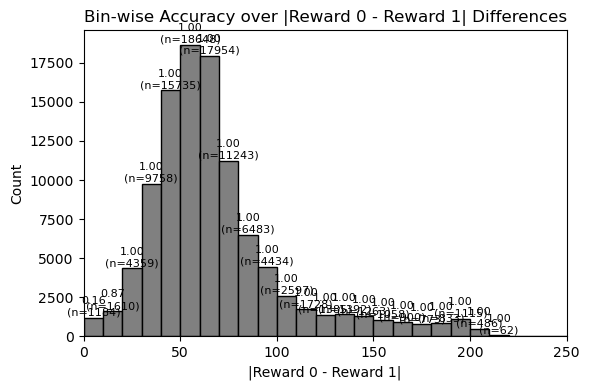

Env: button-press-topdown-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 103872, Correct: 101893, Accuracy: 0.9809


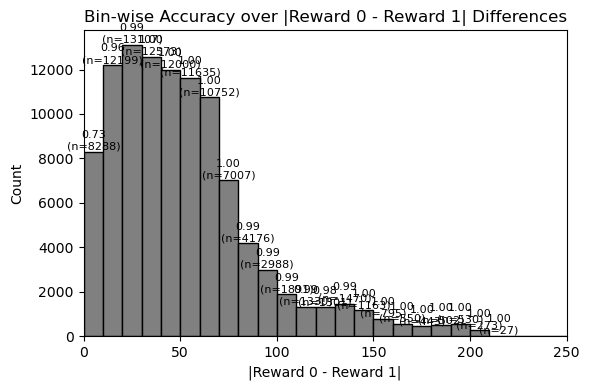

Env: button-press-topdown-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 96246
Total: 95118, Correct: 91647, Accuracy: 0.9635


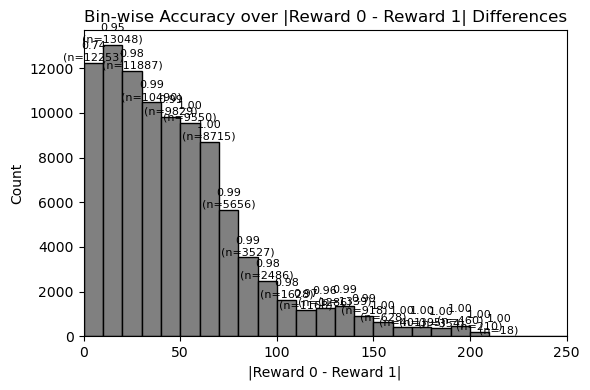

Env: button-press-topdown-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 104999
Total: 103871, Correct: 100709, Accuracy: 0.9696


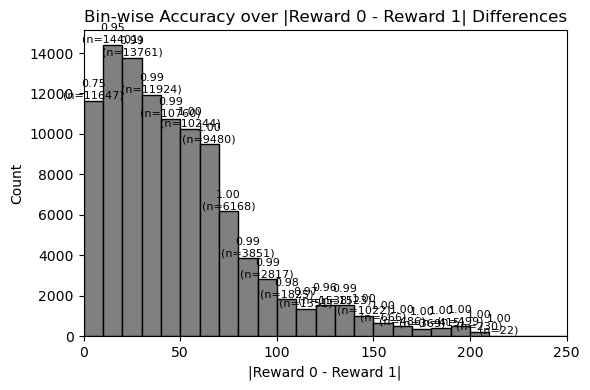

Env: box-close-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 102500, Correct: 100993, Accuracy: 0.9853


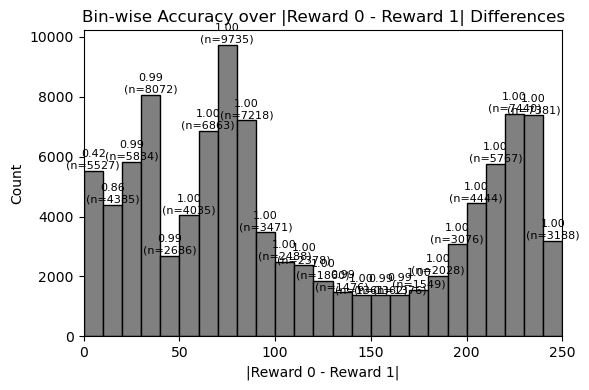

Env: box-close-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 102500, Correct: 93465, Accuracy: 0.9119


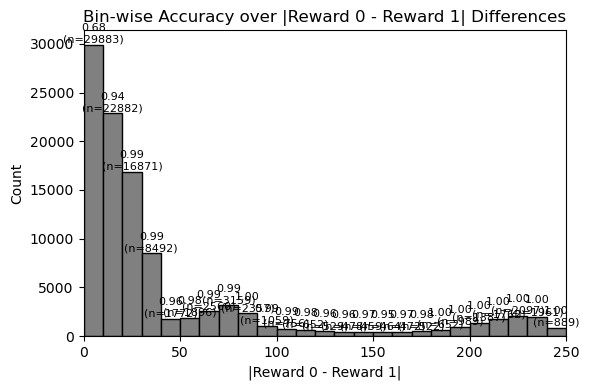

Env: box-close-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 92428
Total: 89928, Correct: 78865, Accuracy: 0.8770


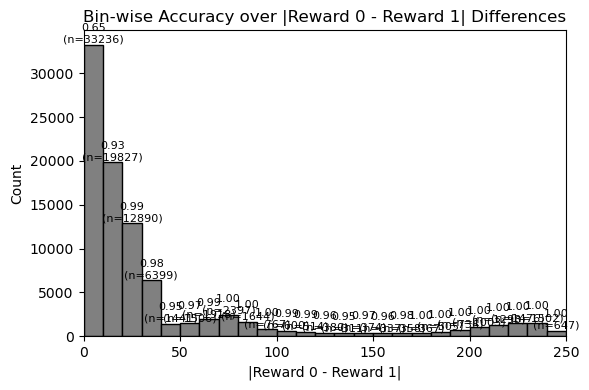

Env: box-close-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 103584
Total: 101084, Correct: 90068, Accuracy: 0.8910


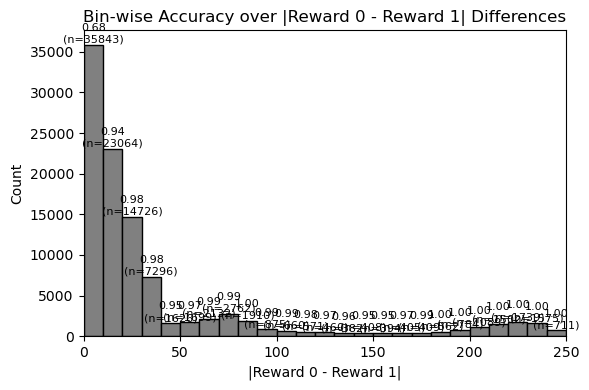

Env: dial-turn-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 104468, Correct: 100505, Accuracy: 0.9621


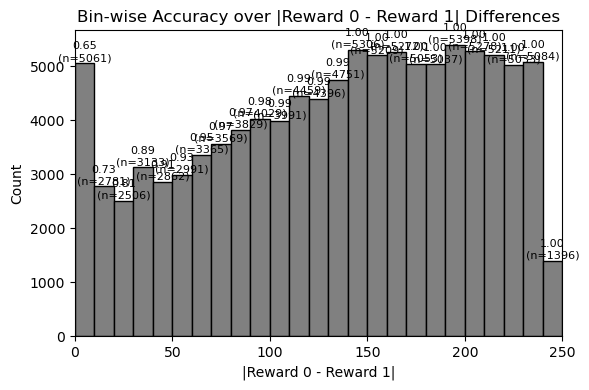

Env: dial-turn-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 104468, Correct: 94025, Accuracy: 0.9000


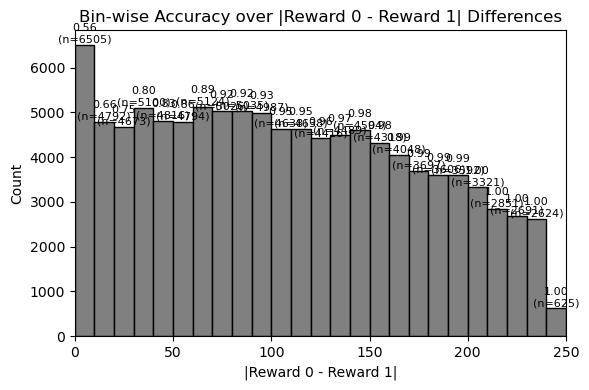

Env: dial-turn-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 84937
Total: 84405, Correct: 72976, Accuracy: 0.8646


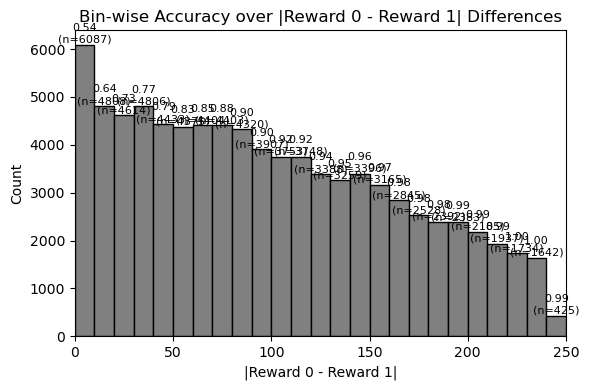

Env: dial-turn-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 99464
Total: 98932, Correct: 84831, Accuracy: 0.8575


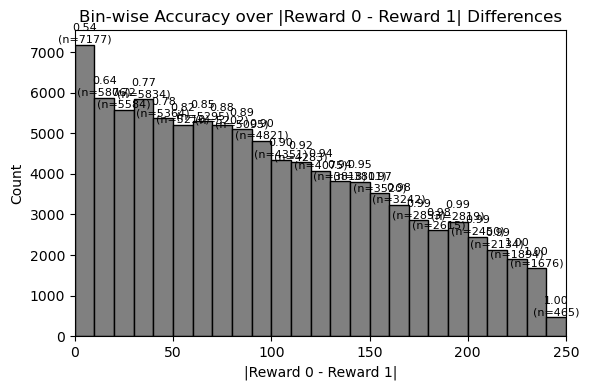

Env: sweep-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 103854, Correct: 102865, Accuracy: 0.9905


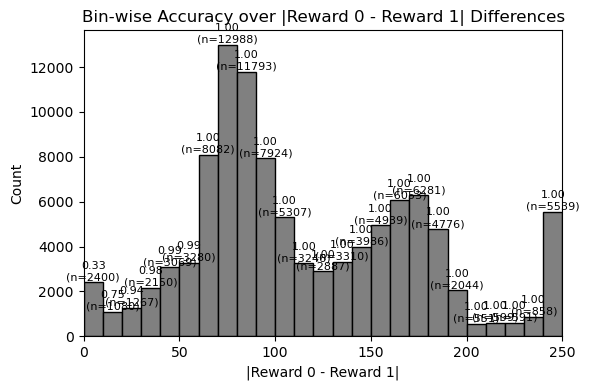

Env: sweep-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 103854, Correct: 96482, Accuracy: 0.9290


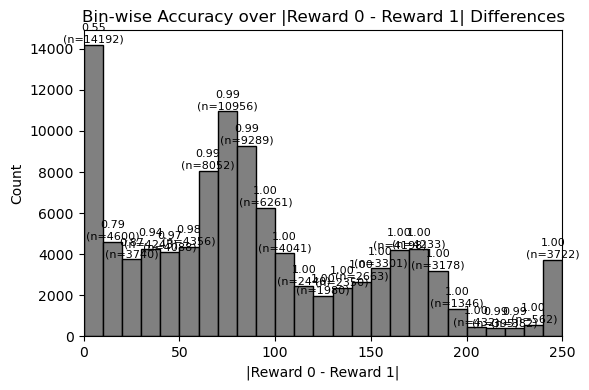

Env: sweep-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 100621
Total: 99475, Correct: 89639, Accuracy: 0.9011


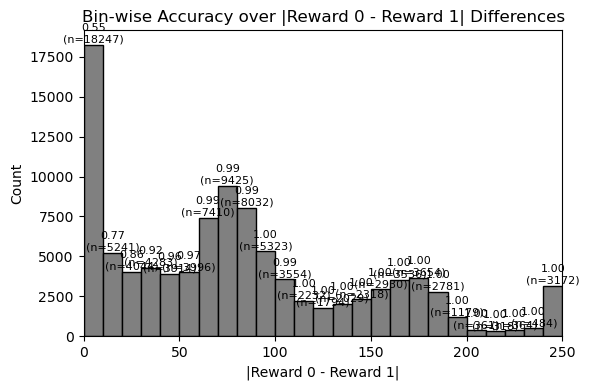

Env: sweep-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 104995
Total: 103849, Correct: 95618, Accuracy: 0.9207


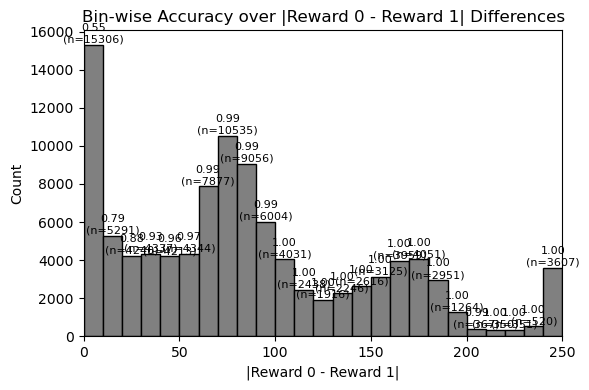

Env: button-press-topdown-wall-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 103894, Correct: 103550, Accuracy: 0.9967


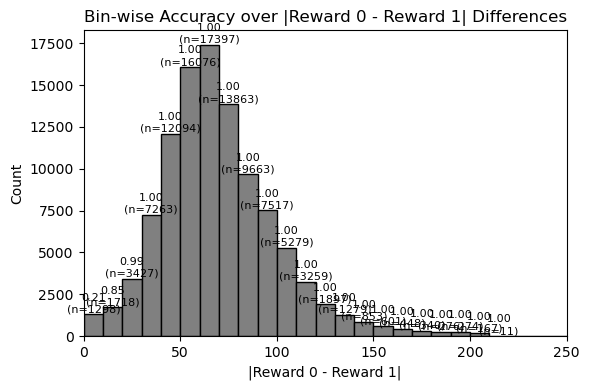

Env: button-press-topdown-wall-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 103894, Correct: 101211, Accuracy: 0.9742


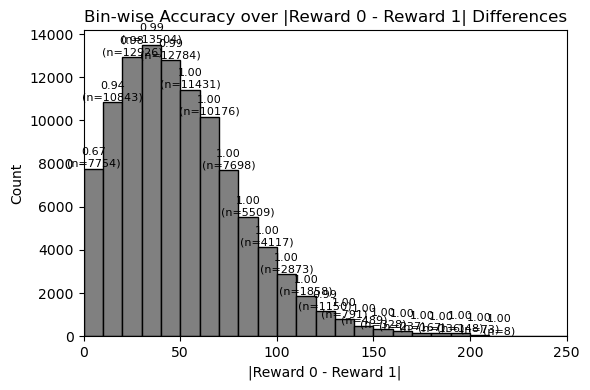

Env: button-press-topdown-wall-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 94710
Total: 93604, Correct: 89629, Accuracy: 0.9575


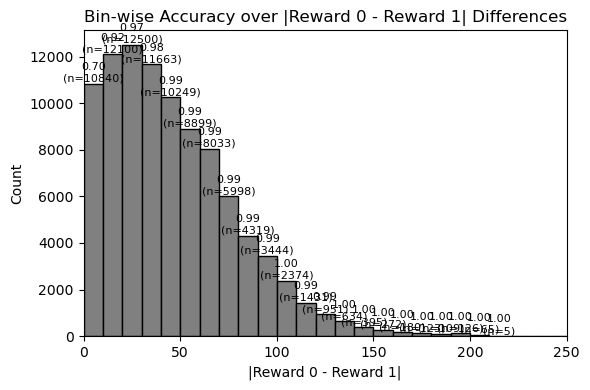

Env: button-press-topdown-wall-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 104471
Total: 103365, Correct: 99510, Accuracy: 0.9627


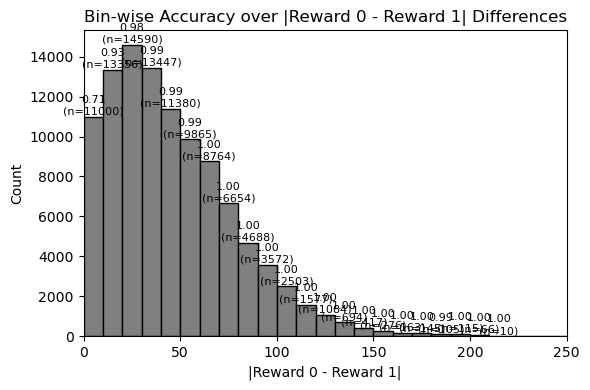

Env: sweep-into-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 102214, Correct: 96081, Accuracy: 0.9400


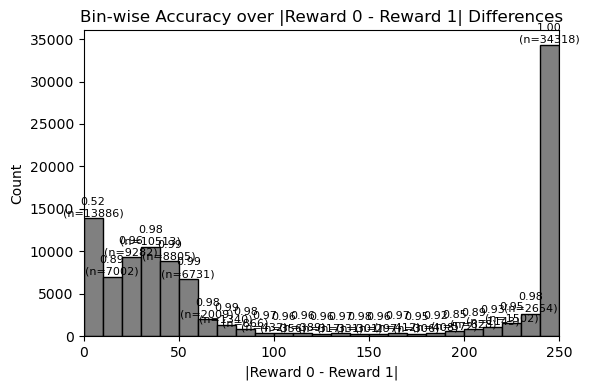

Env: sweep-into-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 102214, Correct: 82031, Accuracy: 0.8025


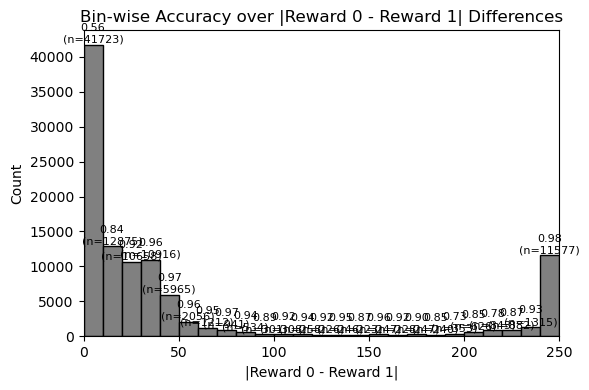

Env: sweep-into-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 93161
Total: 90375, Correct: 67858, Accuracy: 0.7508


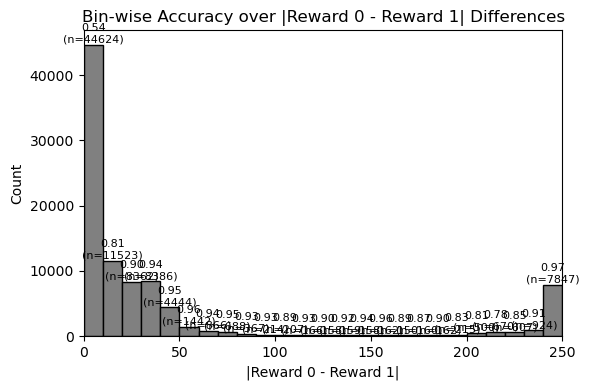

Env: sweep-into-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 104999
Total: 102213, Correct: 76864, Accuracy: 0.7520


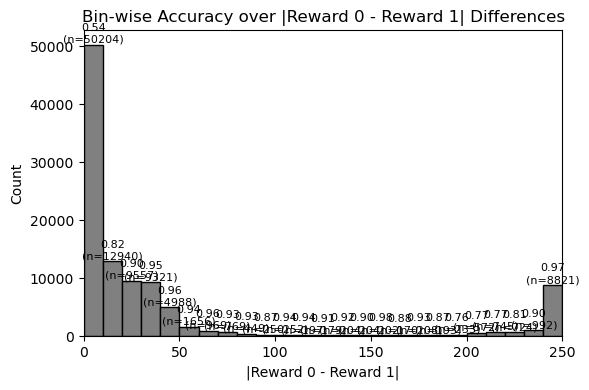

Env: drawer-open-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 104194, Correct: 103682, Accuracy: 0.9951


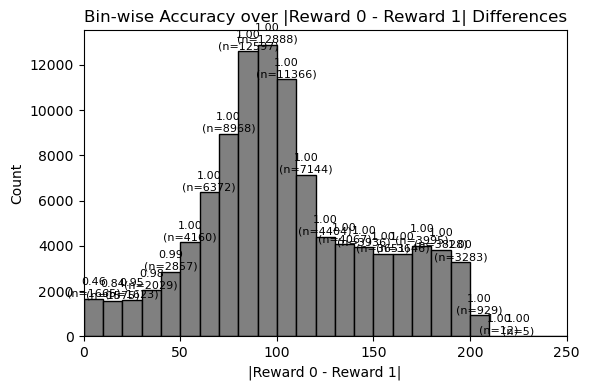

Env: drawer-open-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 104194, Correct: 99653, Accuracy: 0.9564


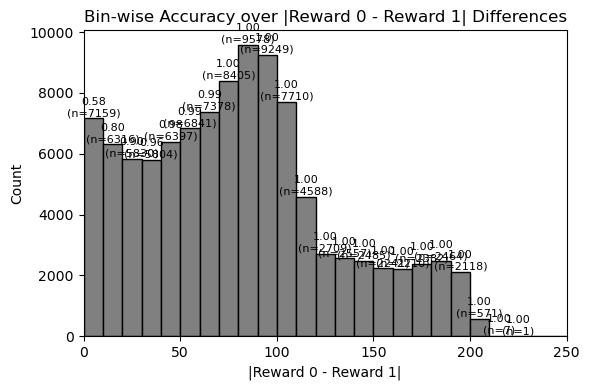

Env: drawer-open-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 100768
Total: 99962, Correct: 92982, Accuracy: 0.9302


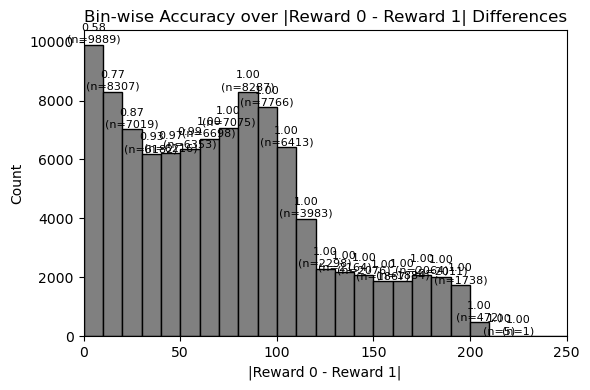

Env: drawer-open-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 105005
Total: 104199, Correct: 98502, Accuracy: 0.9453


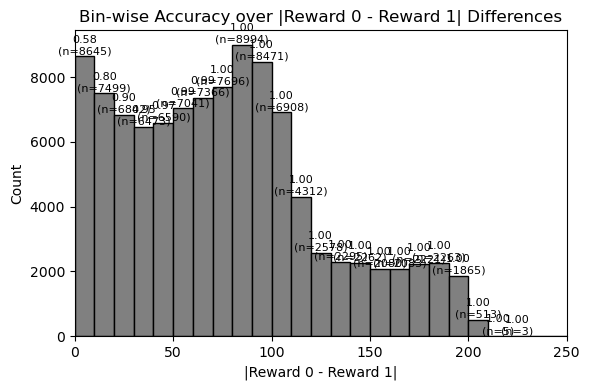

Env: lever-pull-v2, Pair Algo: ternary-500-aug-10000-conf-0.999, Total Pairs: 105000
Total: 102327, Correct: 101821, Accuracy: 0.9951


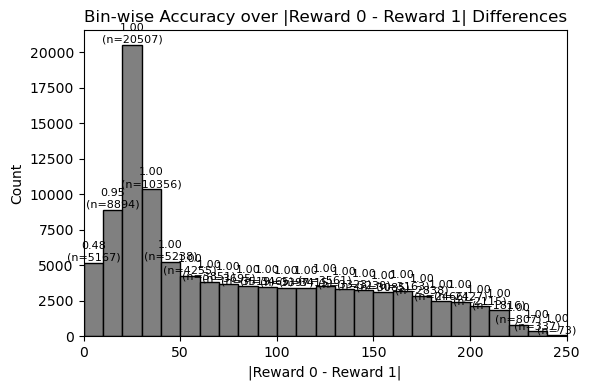

Env: lever-pull-v2, Pair Algo: ternary-500-aug-10000-uncert-3.1, Total Pairs: 105000
Total: 102327, Correct: 97647, Accuracy: 0.9543


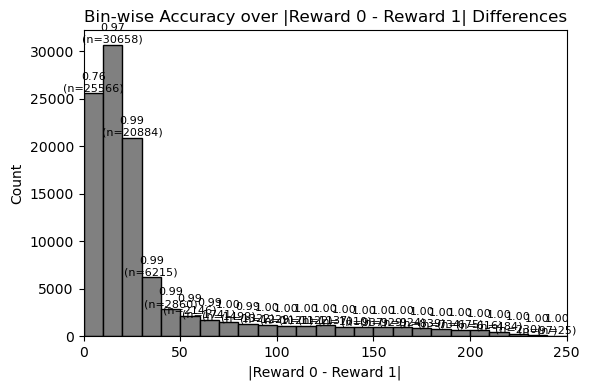

Env: lever-pull-v2, Pair Algo: ternary-500-aug-10000-bucket-20-uncert-3.1, Total Pairs: 83262
Total: 80589, Correct: 75015, Accuracy: 0.9308


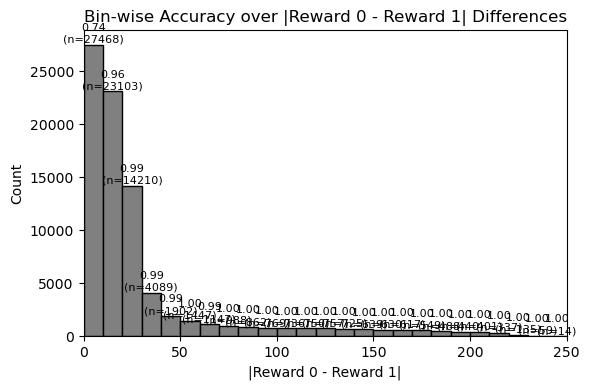

Env: lever-pull-v2, Pair Algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1, Total Pairs: 105007
Total: 102334, Correct: 97443, Accuracy: 0.9522


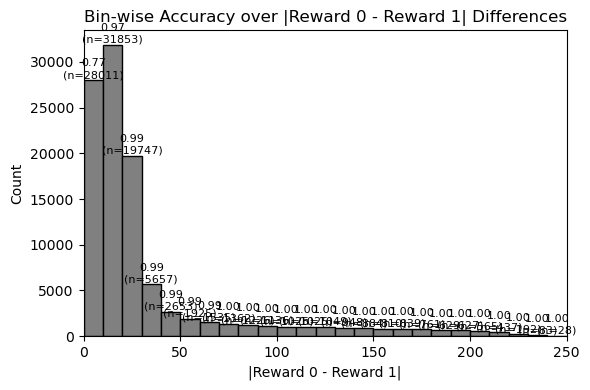

In [5]:
from data_generation.data_research import divide_into_buckets
from data_loading.load_data import load_pair

def sum_pairs(
    env,
    pair_algo,
):
    for i in range(10):
        exp_name = f"CUDA-01-{i:02d}"
        pairs = load_pair(
            env_name=env,
            exp_name=exp_name,
            pair_type="train",
            pair_algo=pair_algo,
        ).tolist()
        if i == 0:
            all_pairs = pairs
        else:
            all_pairs += pairs
        
    return all_pairs

env_list = [
        "button-press-topdown-v2",
        "box-close-v2",
        "dial-turn-v2",
        "sweep-v2",
        "button-press-topdown-wall-v2",
        "sweep-into-v2",
        "drawer-open-v2",
        "lever-pull-v2",
]

pair_algo_list = [
    "ternary-500-aug-10000-conf-0.999",
    "ternary-500-aug-10000-uncert-3.1",
    "ternary-500-aug-10000-bucket-20-uncert-3.1",
    "ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1",
]
for env in env_list:
    for pair_algo in pair_algo_list:
        all_pairs = sum_pairs(env, pair_algo)
        print(f"Env: {env}, Pair Algo: {pair_algo}, Total Pairs: {len(all_pairs)}")

        eval_feedbacks(env_name=env, feedbacks=all_pairs)

